# Introduction to Machine Learning. Assignment 1

Assignment done by Pavel Tishkin

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from scipy import stats

## Data Preprocessing

### Classification

In [2]:
def print_categorical(df: pd.DataFrame):
    for i in range(len(df.columns)):
        if df.dtypes[i] == object:
            col = df.columns[i]
            print(f"Feature {df.columns[i]}. Possible values: {df[col].unique()}")

In [3]:
# Lets first look at the presented data:
df_train_clf = pd.read_csv('Classification/train_data.csv')
df_test_clf = pd.read_csv('Classification/test_data.csv')
df_train_clf.head()

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_bitrate_state,auto_fec_state,auto_fec_mean,stream_quality
0,24.4,0.516398,0,91.1,6.723921,0.0,0.0,0.0,off,partial,50.0,0
1,28.6,2.065591,0,99.7,15.923777,0.0,0.0,0.0,off,partial,50.0,0
2,30.0,0.000000,0,98.1,11.798776,0.0,0.0,0.0,off,partial,50.0,0
3,30.3,0.948683,0,99.4,13.014522,0.0,0.0,0.0,off,partial,50.0,0
4,29.9,0.316228,0,123.2,62.476307,0.0,0.0,0.0,off,partial,50.0,0


In [4]:
# and examine categorical features and their values:
print_categorical(df_train_clf)

Feature auto_bitrate_state. Possible values: ['off' 'full' 'partial']
Feature auto_fec_state. Possible values: ['partial' 'off']


In [5]:
# I think, it is possible to encode all of the features with label encoding, as we can deduce an increasing relationship which can be modelled as 0, 1 and 2: off -> partial -> full and for auto_bitrate_state and off -> auto for auto_fec_state. But for the sake of the broadening our horisons, let us use One Hot Encoder for auto_bitrate_state as it is generally more preferable for categorical features.
def one_hot_encode(df: pd.DataFrame, f_name: str):
    ohe = OneHotEncoder(sparse=False).fit_transform(df[f_name].to_numpy().reshape(-1, 1))
    encoded = pd.DataFrame(ohe, columns=[f"{f_name}{i}" for i in range(ohe.shape[1])])
    return pd.concat([df.drop([f_name], axis=1), encoded], axis=1)

f = 'auto_bitrate_state'
ohe_train_clf = one_hot_encode(df_train_clf, f)
ohe_test_clf = one_hot_encode(df_test_clf, f)

In [6]:
# Next is Label Encoding for auto_fec_state:

def label_encode(df: pd.DataFrame, f_name: str):
    label = LabelEncoder().fit_transform(df[f_name])
    res = df.copy()
    res[f_name] = label
    return res

f = 'auto_fec_state'
prep_train_clf = label_encode(ohe_train_clf, f)
prep_test_clf = label_encode(ohe_test_clf, f)

In [7]:
# We will automatically scale X train and test during creation. No point in applying it to target
def scale(df: pd.DataFrame):
    return pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)

In [8]:
# For classification task the target variable is named stream_quality
X_train_clf, X_test_clf = scale(prep_train_clf.drop(['stream_quality'], axis=1)), scale(prep_test_clf.drop(['stream_quality'], axis=1))
y_train_clf, y_test_clf = prep_train_clf['stream_quality'], prep_test_clf['stream_quality']

### Regression

In [9]:
#Working the same way as in Classification section:
df_train_reg: pd.DataFrame = pd.read_csv('Regression/train_data.csv')
df_train_reg.head()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


In [10]:
df_test_reg: pd.DataFrame = pd.read_csv('Regression/test_data.csv')
# Since regression data does not contain categorical data, we can proceed to MinMax scaling. We'll use def scale() defined previously
reg_train_sc = scale(df_train_reg)
reg_test_sc = scale(df_test_reg)

In [11]:
# for regression task the target feature is named target:
X_train_reg, X_test_reg = reg_train_sc.drop(['target'], axis=1), reg_test_sc.drop(['target'], axis=1)
y_train_reg, y_test_reg = reg_train_sc['target'], reg_test_sc['target']

In [12]:
y_train_clf, y_test_clf = y_train_clf.astype(int), y_test_clf.astype(int)

# Feature Selection and Engineering

# Regression

In [13]:
from sklearn.feature_selection import f_regression, f_classif

We will use 2 statistical tests for regression and classification.
h0 - Variable is independent from target variable
h1 - Variable is dependent on target variable

If we obtain low p-value, we can reject H0 and let the feature stay
For regression we will calculate f-score and get p-values from it

<AxesSubplot:>

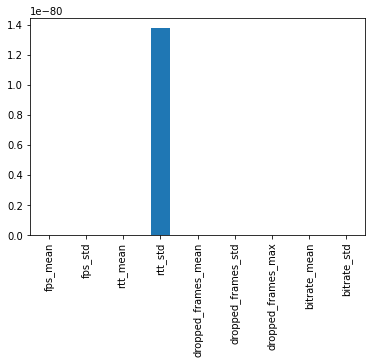

In [14]:
pd.Series(f_regression(X_train_reg, y_train_reg)[1], index=X_train_reg.columns).plot.bar()

Since we need to somehow reduce the dimensionality (H0 was rejected in all cases), we can remove the feature with the highest p-value (rtt_std)

In [15]:
X_train_reg, X_test_reg = X_train_reg.drop(['rtt_std'], axis=1), X_test_reg.drop(['rtt_std'], axis=1)

# Classification

Repeating the process, as in regression part, we can use ANOVA to get the p-values, using the same hypotheses:

<AxesSubplot:>

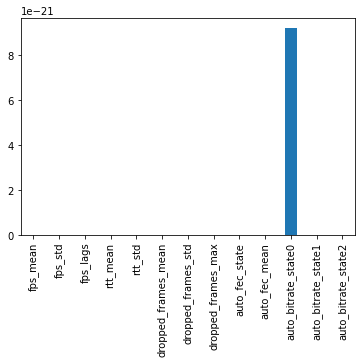

In [16]:
pd.Series(f_classif(X_train_clf, y_train_clf)[1], index=X_train_clf.columns).plot.bar()

Once again, we can drop the value only for the sake of the task: (auto_bitrate_state0 - one of the OHE features)

In [17]:
X_train_clf, X_test_clf = X_train_clf.drop(['auto_bitrate_state0'], axis=1), X_test_clf.drop(['auto_bitrate_state0'], axis=1)

## Data visualizations

In [18]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_train_clf, title="Pandas Profiling Report")
profile.to_file("report_clf.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
profile = ProfileReport(df_train_reg, title="Pandas Profiling Report")
profile.to_file("report_reg.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\scipy\stats\stats.py:4594: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

PCA of regression data:


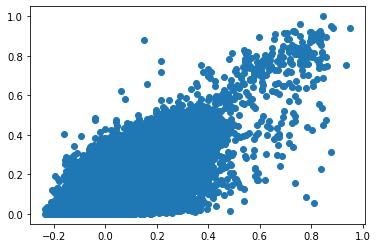

In [20]:
#Want to use PCA
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

print("PCA of regression data:")
projected = PCA(1).fit_transform(X_train_reg)
plt.scatter(projected, y_train_reg)
plt.show()

PCA of classification data:


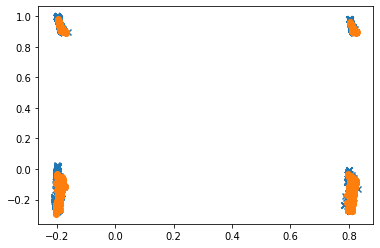

In [21]:
projected = PCA(2).fit_transform(X_train_clf)
print("PCA of classification data:")
positive = np.array(list(map(lambda x: x[0], list(filter(lambda x: x[1] == 1, zip(projected, y_train_clf))))))
negative = np.array(list(map(lambda x: x[0], list(filter(lambda x: x[1] == 0, zip(projected, y_train_clf))))))
plt.scatter(positive[:, 0], positive[:, 1], marker='x')
plt.scatter(negative[:, 0], negative[:, 1], marker='o')
plt.show()

# Machine Learning models

## Regression

In [22]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
# https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2

In [23]:
model1 = LinearRegression()
model2 = Ridge()
model1.fit(X_train_reg, y_train_reg)
model2.fit(X_train_reg, y_train_reg)

y_pred_reg1 = model1.predict(X_test_reg)
y_pred_reg2 = model2.predict(X_test_reg)

For polynomial regression, we would need to tweak the degree. We will try increasing it and see if MSE changes for better or worse:

In [24]:
from sklearn.metrics import mean_squared_error
res = []

for i in range(2, 5):
    poly = make_pipeline(PolynomialFeatures(i), LinearRegression())
    poly.fit(X_train_reg, y_train_reg)
    y_pred_reg3 = poly.predict(X_test_reg)
    res.append(mean_squared_error(y_test_reg, y_pred_reg3))

In [25]:
print(res)

[0.0009762072661743507, 0.04745554170209508, 1365222.3476492097]


## Classification

In [26]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(penalty='l2', max_iter=120000)
logistic.fit(X_train_clf, y_train_clf)
y_pred_clf = logistic.predict(X_test_clf)

# Performance evaluation

## Regression

To evaluate the performance of the models, we are going to use RMSE (the default parameter is true for sklearn MSE, making it RMSE). Let's start with cross validation of our models:

In [27]:
from sklearn.model_selection import cross_val_score

model1 = LinearRegression()
model2 = Ridge()
model3 = make_pipeline(PolynomialFeatures(2), LinearRegression())

m1_cross = cross_val_score(model1, X_train_reg, y_train_reg, cv=5)
m2_cross = cross_val_score(model2, X_train_reg, y_train_reg, cv=5)
m3_cross = cross_val_score(model3, X_train_reg, y_train_reg, cv=5)

print(f'Model 1 Cross Validation mean: {np.mean(m1_cross)}, std: {np.std(m1_cross)}')
print(f'Model 2 Cross Validation mean: {np.mean(m2_cross)}, std: {np.std(m2_cross)}')
print(f'Model 3 Cross Validation mean: {np.mean(m3_cross)}, std: {np.std(m3_cross)}')

Model 1 Cross Validation mean: 0.8922780099688236, std: 0.00959089453787734
Model 2 Cross Validation mean: 0.8922801071540768, std: 0.009589947368565103
Model 3 Cross Validation mean: 0.8904863196266785, std: 0.012681118545217786


As we can see, all of them are well fitted, no over or underfitting, since std is low, except for the 3rd model, which is a bit overfitted (as demonstrated in degree selection). Now, lets see the performance on the whole dataset:

In [28]:
print(f'Model 1 (Linear) - MSE:{mean_squared_error(y_test_reg, y_pred_reg1)}')
print(f'Model 2 (Linear + Ridge) - MSE:{mean_squared_error(y_test_reg, y_pred_reg2)}')
print(f'Model 3 (Polynomial with degree {np.argmin(res) + 2}) - MSE:{res[np.argmin(res)]}')

Model 1 (Linear) - MSE:0.0009473950636717554
Model 2 (Linear + Ridge) - MSE:0.0009474109187449936
Model 3 (Polynomial with degree 2) - MSE:0.0009762072661743507


As we can see, the Polynomial regression was unnecessary (model suffers from overfitting drastically for having degree higher than 2). Interestingly, lack of regularization makes model work better. The models do not suffer from overfitting

## Classification

In [29]:
logistic = LogisticRegression(penalty='l2', max_iter=120000)

log_cross = cross_val_score(logistic, X_train_clf, y_train_clf, cv=5)
print(f'Logistic Regression Cross Validation mean: {np.mean(log_cross)}, std: {np.std(log_cross)}')

Logistic Regression Cross Validation mean: 0.9446666649455662, std: 0.00793879885764583


As we can see, the model did not fit properly, as the loss is high, on the other hand, it std between bins is not high, but slightly overfitted

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test_clf, y_pred_clf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    227902
           1       0.53      0.20      0.29     15694

    accuracy                           0.94    243596
   macro avg       0.74      0.59      0.63    243596
weighted avg       0.92      0.94      0.92    243596



As we can see, the classification model suffers prediction class 1, as the dataset is imbalanced (approximately 6% of labels are of class 1). Weighted average is the weighted by percentage of support sum of metrics for the classes. It demonstrates only the imbalance of the dataset. Macro average is more representative in this case (just a mean of metric values for 2 classes)

# Data Balancing and Outlier detection

In [31]:
import seaborn as sns

In [32]:
X_train_clf.head(1)

,fps_mean,fps_std,fps_lags,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,auto_fec_state,auto_fec_mean,auto_bitrate_state1,auto_bitrate_state2
0,0.191975,0.001652,0.0,0.007063,0.000165,0.0,0.0,0.0,1.0,0.2,1.0,0.0


<AxesSubplot:xlabel='fps_mean'>

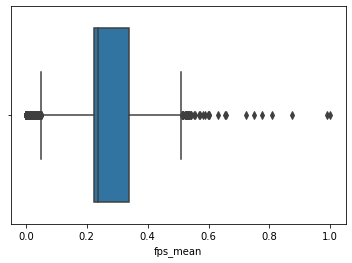

In [33]:
sns.boxplot(x=X_train_clf.fps_mean)

Well, there are a lot of outliers. We need to remove them. We will use Z-score method from the article: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [34]:
X_train_clf_o = X_train_clf.copy()
X_train_clf_o['target'] = y_train_clf
z = np.abs(stats.zscore(X_train_clf))

X_train_clf_o = X_train_clf_o[(z < 3).all(axis=1)]

In [35]:
print(f'Removed Outliers: {X_train_clf.shape[0] - X_train_clf_o.shape[0]}')

Removed Outliers: 30748


In [36]:
# Now, splitting the sets to X y for sampling:
X_train_clf_o, y_train_clf_o = X_train_clf_o.drop('target', axis=1), X_train_clf_o['target']

For sampling, lets choose the oversampling of the minority class technique:

In [37]:
from imblearn.over_sampling import RandomOverSampler
smt = RandomOverSampler(sampling_strategy='minority')
X_res, y_res = smt.fit_resample(X_train_clf_o, y_train_clf_o)

In [38]:
logistic = LogisticRegression(penalty='l2', max_iter=120000)

logistic.fit(X_res, y_res)

print(f'Number of classes: 0 - {sum(y_res == 0)}, 1 - {sum(y_res == 1)}')

log_cross = cross_val_score(logistic, X_res, y_res, cv=5)
print(f'Logistic Regression with sampling Cross Validation mean: {np.mean(log_cross)}, std: {np.std(log_cross)}')

y_pred = logistic.predict(X_test_clf)
print(classification_report(y_test_clf, y_pred))

Number of classes: 0 - 357310, 1 - 357310
Logistic Regression with sampling Cross Validation mean: 0.6540636981892474, std: 0.008097070288443666
              precision    recall  f1-score   support

           0       0.97      0.74      0.84    227902
           1       0.15      0.67      0.24     15694

    accuracy                           0.73    243596
   macro avg       0.56      0.70      0.54    243596
weighted avg       0.92      0.73      0.80    243596



Now, lets reprint the results without outliers detection and sampling

In [39]:
print(classification_report(y_test_clf, y_pred_clf))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    227902
           1       0.53      0.20      0.29     15694

    accuracy                           0.94    243596
   macro avg       0.74      0.59      0.63    243596
weighted avg       0.92      0.94      0.92    243596



As we can see, there were some improvements to recall, but we sacrificed the precision of the model. Nonetheless, the f1-score increased a little bit. Accuracy also improved